Goal - convenience functions to parse HA data into useful format for data science. Consider creating a class to hold the data.
SQLAlchemy is used in this notebook but other suitable libraries are available.

* http://www.sqlalchemy.org/
* https://facebook.github.io/prophet/

Using Google cloud data

In [80]:
%matplotlib inline
from datetime import datetime
from sqlalchemy import create_engine, text
import json
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from fbprophet import Prophet

In [2]:
def load_url(filename):
    """Convenience for loading a url from a json file."""
    try:
        with open(filename, 'r') as fp:
            url = json.load(fp)
    except Exception as e:
        print('Failed to load url')
        url = None
    return url['url']

Some helper functions for parsing HA data

In [3]:
def time_category(dtObj):
    """Return a time category, bed, home, work, given a datetime object dtObj."""
    if 9 <= dtObj.hour <= 17:
        return 'daytime'
    elif 5 <= dtObj.hour < 9:
        return 'morning'
    elif 17 < dtObj.hour < 23:
        return 'evening'
    else:
        return 'night'

In [4]:
def is_weekday(dtObj):
    """Check a datetime object dtObj is a weekday"""
    if dtObj.weekday() < 5:
        return True
    else:
        return False

In [5]:
def isfloat(value):
    """Check if string can be parsed to a float."""
    try:
        float(value)
        return True
    except ValueError:
        return False

isfloat('23.6')

True

In [6]:
def parse_state(value):
    """Check if state can be parsed to a float."""
    try:
        float(value)
        return float(value)
    except ValueError:
        return value

val = parse_state('23.6')

In [7]:
parse_state('foo')

'foo'

In [8]:
def binary_state(value):
    """Return a binary for the state of binary sensors"""
    if  value == 'on':
        return True
    elif value == 'off':
        return False
    else:
        return float('nan')

print(binary_state('on'))
print(binary_state('off'))
print(binary_state('foo'))

True
False
nan


In [9]:
def rename_entity(entity_id):
    """Takes an entity_if of form sensor.name and returns name."""
    return entity_id.split('.')[1]

rename_entity('sensor.bme680humidity')

'bme680humidity'

Conveninece to query and filter list of entities

In [10]:
def query_entities(*args, **kwargs):
    """Takes a query term or terms and returns a list of entities satisfying the term. 
    Additionally apply a single filter term. 
    Example usage = query_entities('temperature', 'light', filter='sensor)"""
    query_results = [entity for entity in entity_list if any(query in entity for query in args)] 
    if kwargs['filter']:
        filtered_resaults = [entity for entity in query_results if kwargs['filter'] in entity]
        return filtered_resaults
    else:
        return query_results

Convenience function for checking a state. This is incredibly slow when applied to large data frames. Better approach is place data on time index and fill.

In [11]:
def state_at_time(df, dtObj):
    """Check the last registered state at some time using asof.
    Passed df needs to be time indexed and should only include the entitiy_id of interest."""
    found_index = df.index.asof(dtObj)     # Find the closest index asof time test_time
    if pd.isnull(found_index):             # If dtObj is before the first index of dt, will return NaT
        return float('nan')
    else:
        state = df.loc[found_index]['state']      # Get the state at the found_index
        return state

## Fetch the states data

In [12]:
filename = '/Users/robincole/Desktop/hass_db_url.json'
DB_URL = load_url(filename)

In [13]:
engine = create_engine(DB_URL)

In [14]:
%%time
entity_id_list =  list(engine.execute("SELECT entity_id, COUNT(*) FROM states \
GROUP BY entity_id ORDER by 2 DESC"))

CPU times: user 11.3 ms, sys: 6.03 ms, total: 17.4 ms
Wall time: 7.21 s


In [15]:
len(entity_id_list)

133

In [16]:
entity_list = list(zip(*entity_id_list))[0]

In [17]:
entity_list[0:5]

('sensor.bme680humidity',
 'sensor.bme680pressure',
 'sensor.bme680temperature',
 'sun.sun',
 'sensor.time__date')

Select all state data for last X days, store in a single dataframe for convenience

In [18]:
%%time
# query to pull all rows form the states table where last_changed field is on \
# or after the date_filter value
#stmt = text("SELECT * FROM states where last_changed>=:date_filter")
stmt = text("""SELECT domain, entity_id, state, last_changed FROM states WHERE NOT state='unknown' """)

# bind parameters to the stmt value, specifying the date_filter to be 10 days \
# before today
#stmt = stmt.bindparams(date_filter=datetime.now()-timedelta(days=100))

# execute the SQL statement
allquery = engine.execute(stmt)

# get rows from query into a pandas dataframe
allqueryDF = pd.DataFrame(allquery.fetchall())

CPU times: user 4.1 s, sys: 970 ms, total: 5.07 s
Wall time: 48.3 s


In [19]:
allqueryDF.shape

(694358, 4)

In [20]:
print("The dataframse size on disk is {} MB".format(allqueryDF.values.nbytes/1e6))

The dataframse size on disk is 22.219456 MB


Name the columns, need to look into the difference between last_changed & last_updated

In [21]:
allqueryDF.columns = ['domain', 'entity', 'state', 'last_changed']

In [22]:
allqueryDF.head()

,domain,entity,state,last_changed
0,zone,zone.work,zoning,2017-12-25 07:30:00.355109+00:00
1,zone,zone.home,zoning,2017-12-25 07:30:00.356669+00:00
2,zone,zone.waterloo,zoning,2017-12-25 07:30:00.360553+00:00
3,sun,sun.sun,below_horizon,2017-12-25 07:30:00.369863+00:00
4,input_boolean,input_boolean.house_idle,off,2017-12-25 07:30:00.432193+00:00


Lets copy the master df in case we want to recover the original.
Also we would like to know if states are numerical or not

In [23]:
df = allqueryDF

In [24]:
df.iloc[0]['last_changed']

Timestamp('2017-12-25 07:30:00.355109+0000', tz='psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)')

Lets drop the timezone and work with naive timestamps

In [25]:
#df['last_changed'] = df['last_changed'].apply(lambda x: x.tz_convert(tz))

In [26]:
df['last_changed'] = df['last_changed'].apply(lambda x: x.tz_localize(None))

In [27]:
df['last_changed'] = pd.to_datetime(df['last_changed'], format="%Y:%m:%d %H:%M:%S") 

In [28]:
df.iloc[-1]['last_changed']

Timestamp('2018-01-21 07:07:54.424510')

In [29]:
df['numerical'] = df['state'].apply(lambda x: isfloat(x)) 

In [30]:
#allqueryDF['state'] = allqueryDF['state'].apply(lambda state: parse_state(state))  # Lets convert the numericals into floats 

In [31]:
df.tail()

,domain,entity,state,last_changed,numerical
694353,sensor,sensor.living_room_motion_sensor,on,2018-01-21 07:07:54.396001,False
694354,group,group.hue,on,2018-01-21 07:07:54.403498,False
694355,binary_sensor,binary_sensor.motion_at_home,on,2018-01-21 07:07:54.405512,False
694356,binary_sensor,binary_sensor.in_bed_bayesian,off,2018-01-21 07:00:01.385828,False
694357,sensor,sensor.bayes_probability,0.27,2018-01-21 07:07:54.424510,True


Convert to multi-index

In [32]:
df = df[['domain', 'entity', 'last_changed', 'numerical', 'state']].set_index(['domain', 'entity', 'numerical', 'last_changed'])
df.head()

state
domain        entity                   numerical last_changed                             
zone          zone.work                False     2017-12-25 07:30:00.355109         zoning
              zone.home                False     2017-12-25 07:30:00.356669         zoning
              zone.waterloo            False     2017-12-25 07:30:00.360553         zoning
sun           sun.sun                  False     2017-12-25 07:30:00.369863  below_horizon
input_boolean input_boolean.house_idle False     2017-12-25 07:30:00.432193            off

## Numerical data
lets do a query for numerical sensor

In [33]:
num_sensors_df = df.query('domain == "sensor" & numerical == True')
num_sensors_df['state'] = num_sensors_df['state'].astype('float')
num_sensors_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


state
domain entity                           numerical last_changed                            
sensor sensor.bme680temperature         True      2017-12-25 07:30:02.032540  2.103000e+01
       sensor.bme680air_qual            True      2017-12-25 07:30:02.040975  9.818021e+06
       sensor.electric_charger_distance True      2017-12-25 07:30:05.223131  7.530904e-01
       sensor.network_up                True      2017-12-25 07:30:16.917245  4.000000e+00
       sensor.bme680humidity            True      2017-12-25 07:30:02.022880  5.544800e+01

In [34]:
num_sensors_list = list(num_sensors_df.index.get_level_values('entity').unique())
print(len(num_sensors_list))
num_sensors_list

27


['sensor.bme680temperature',
 'sensor.bme680air_qual',
 'sensor.electric_charger_distance',
 'sensor.network_up',
 'sensor.bme680humidity',
 'sensor.bme680pressure',
 'sensor.darksky_sensor_precip_probability',
 'sensor.darksky_sensor_temperature',
 'sensor.blink_blink_camera_percy_temperature',
 'sensor.mean_temperature',
 'sensor.robins_iphone_battery_level',
 'sensor.blink_blink_camera_percy_notifications',
 'sensor.iphone_battery_level',
 'sensor.bayes_probability',
 'sensor.work_to_home',
 'sensor.home_to_work',
 'sensor.home_to_waterloo',
 'sensor.memory_usage_real',
 'sensor.volume_used_volume_1',
 'sensor.cpu_load_total',
 'sensor.hall_temperature',
 'sensor.living_room_temperature',
 'sensor.bedroom_temperature',
 'sensor.next_train_in',
 'sensor.speedtest_download',
 'sensor.next_train_to_wim',
 'sensor.time_in_bed']

Lets do a pivot to get sensors in columns to make plotting convenient. Lets also forward fill the data

In [35]:
num_sensors_df = num_sensors_df.pivot_table(index='last_changed', columns='entity', values='state')
num_sensors_df = num_sensors_df.fillna(method='ffill')
num_sensors_df = num_sensors_df.dropna() # drop any remaining nan
num_sensors_df.index = pd.to_datetime(num_sensors_df.index)

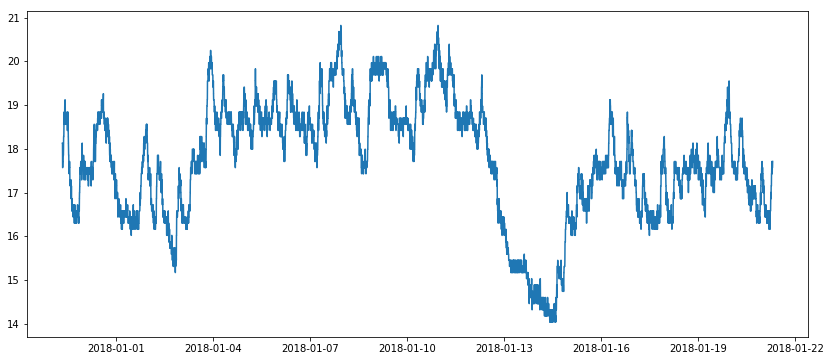

In [36]:
height=6
width=14
figsize=(width, height)

df_plot = num_sensors_df['sensor.living_room_temperature']
last_time = df_plot.index[-1]
hours_to_plot = 24
xfmt = md.DateFormatter('%m/%d') # %m-

f, ax = plt.subplots(1, 1, figsize=(width, height))
ax.plot(df_plot)
#ax.xaxis.set_major_formatter(xfmt)
#ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now);

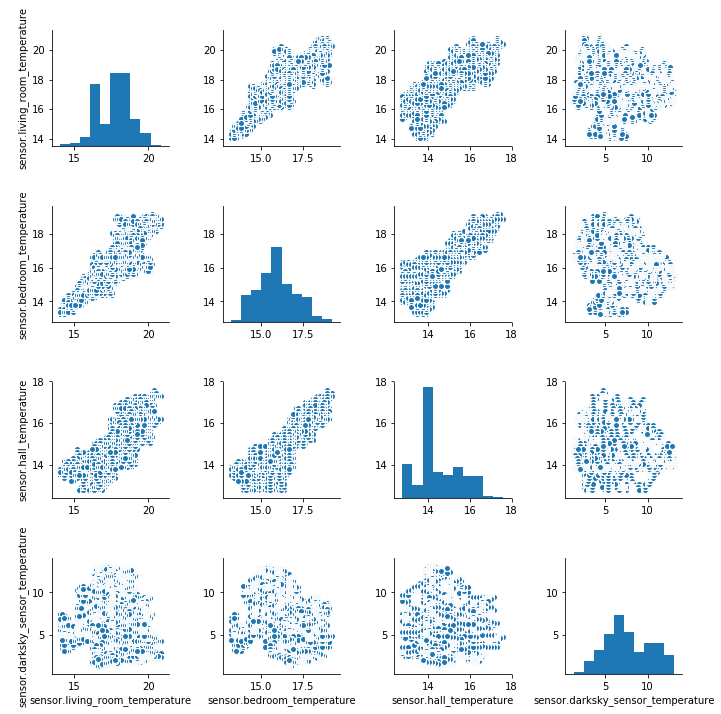

In [37]:
sns_plot = sns.pairplot(num_sensors_df[['sensor.living_room_temperature',
'sensor.bedroom_temperature',
'sensor.hall_temperature', 
'sensor.darksky_sensor_temperature']]);

sns_plot.savefig("pairplot.png")

## Single temperature sensor

In [38]:
stmt = text("""
SELECT last_changed, state 
FROM states 
WHERE NOT state='unknown' 
AND states.entity_id = 'sensor.darksky_sensor_temperature'
""")

query = engine.execute(stmt)

# get rows from query into a pandas dataframe
darksky_sensor_temperature = pd.DataFrame(query.fetchall())

In [39]:
darksky_sensor_temperature.head()

,0,1
0,2017-12-25 07:30:07.679411+00:00,9.5
1,2017-12-25 08:33:56.909285+00:00,9.3
2,2017-12-25 09:15:07.994419+00:00,9.4
3,2017-12-25 09:27:30.920648+00:00,9.5
4,2017-12-25 09:33:42.997302+00:00,9.3


In [40]:
darksky_sensor_temperature.iloc[0][0]

Timestamp('2017-12-25 07:30:07.679411+0000', tz='psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)')

In [41]:
darksky_sensor_temperature[0] = darksky_sensor_temperature[0].apply(lambda x: x.tz_localize(None))

In [42]:
darksky_sensor_temperature.iloc[0][0]

Timestamp('2017-12-25 07:30:07.679411')

In [43]:
#darksky_sensor_temperature.columns = ['last_changed', 'state']
#darksky_sensor_temperature.set_index('last_changed', inplace=True)
#darksky_sensor_temperature.index = pd.to_datetime(darksky_sensor_temperature.index)
#darksky_sensor_temperature['state'] = darksky_sensor_temperature['state'].astype('float')
#darksky_sensor_temperature.head()

In [44]:
darksky_sensor_temperature.columns = ['last_changed', 'state']
darksky_sensor_temperature['last_changed']= pd.to_datetime(darksky_sensor_temperature['last_changed'], utc=True)
darksky_sensor_temperature['state'] = darksky_sensor_temperature['state'].astype('float')
darksky_sensor_temperature.head()

,last_changed,state
0,2017-12-25 07:30:07.679411+00:00,9.5
1,2017-12-25 08:33:56.909285+00:00,9.3
2,2017-12-25 09:15:07.994419+00:00,9.4
3,2017-12-25 09:27:30.920648+00:00,9.5
4,2017-12-25 09:33:42.997302+00:00,9.3


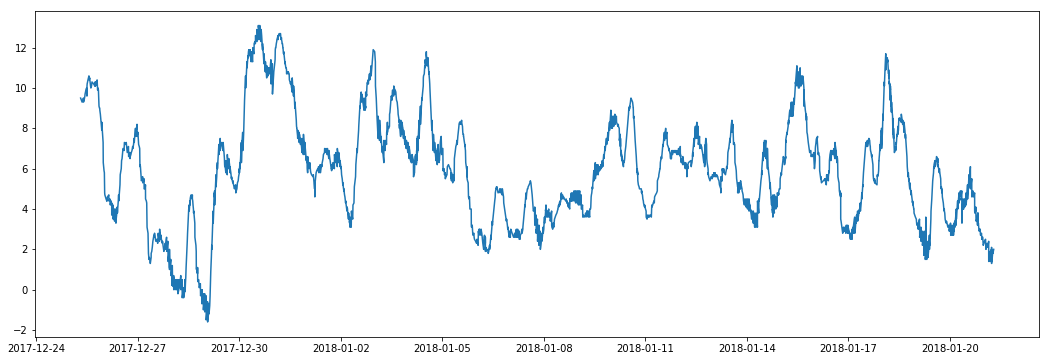

In [45]:
height=6
width=18
figsize=(width, height)

f, ax = plt.subplots(1, 1, figsize=(width, height))
ax.plot(darksky_sensor_temperature['last_changed'], darksky_sensor_temperature['state'])

## Prophet
Lets try some prediction with prophet

In [46]:
df = darksky_sensor_temperature.copy()

In [47]:
df.columns = ['ds', 'y']

In [48]:
df.iloc[0]['ds']

Timestamp('2017-12-25 07:30:07.679411+0000', tz='UTC')

In [49]:
df['ds'] = df['ds'].apply(lambda x: x.tz_localize(None))

In [50]:
df.iloc[0]['ds']

Timestamp('2017-12-25 07:30:07.679411')

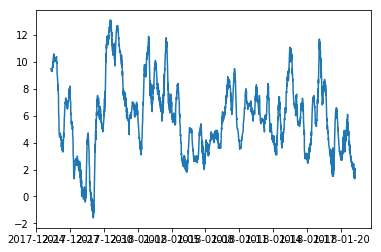

In [51]:
plt.plot(df['ds'], df['y'])

In [52]:
% time
m = Prophet()
m.fit(df);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
future = m.make_future_dataframe(periods=365, freq='H')

In [54]:
future.head()

,ds
0,2017-12-25 07:30:07.679411
1,2017-12-25 08:33:56.909285
2,2017-12-25 09:15:07.994419
3,2017-12-25 09:27:30.920648
4,2017-12-25 09:33:42.997302


In [55]:
future.iloc[0]['ds'] # Daily forecasts

Timestamp('2017-12-25 07:30:07.679411')

In [56]:
forecast = m.predict(future)

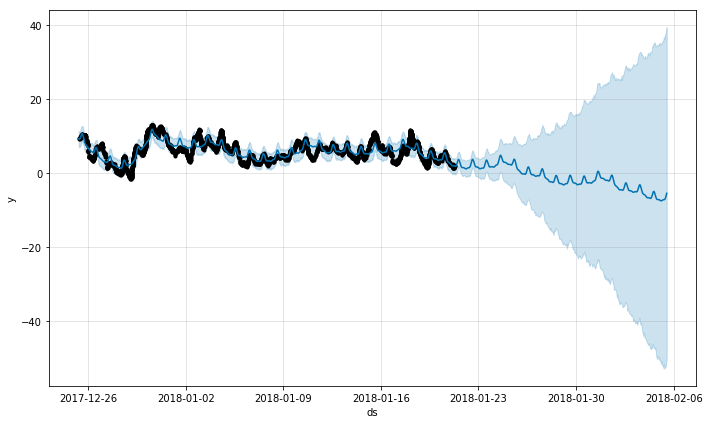

In [57]:
m.plot(forecast);

In [60]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
0,2017-12-25 07:30:07.679411,10.710064,10.710064,10.710064,7.208406,11.335603,-0.515178,-0.515178,-0.515178,-1.444745,-1.444745,-1.444745,-1.444745,-1.444745,-1.444745,-0.929567,-0.929567,-0.929567,9.265320
1,2017-12-25 08:33:56.909285,10.526394,10.526394,10.526394,7.027743,11.271120,-0.479364,-0.479364,-0.479364,-1.364508,-1.364508,-1.364508,-1.364508,-1.364508,-1.364508,-0.885144,-0.885144,-0.885144,9.161886
2,2017-12-25 09:15:07.994419,10.407868,10.407868,10.407868,7.125783,11.233006,-0.353628,-0.353628,-0.353628,-1.210716,-1.210716,-1.210716,-1.210716,-1.210716,-1.210716,-0.857088,-0.857088,-0.857088,9.197152
3,2017-12-25 09:27:30.920648,10.372233,10.372233,10.372233,7.165693,11.227112,-0.293884,-0.293884,-0.293884,-1.142654,-1.142654,-1.142654,-1.142654,-1.142654,-1.142654,-0.848769,-0.848769,-0.848769,9.229580
4,2017-12-25 09:33:42.997302,10.354387,10.354387,10.354387,7.167692,11.360290,-0.259896,-0.259896,-0.259896,-1.104521,-1.104521,-1.104521,-1.104521,-1.104521,-1.104521,-0.844625,-0.844625,-0.844625,9.249865


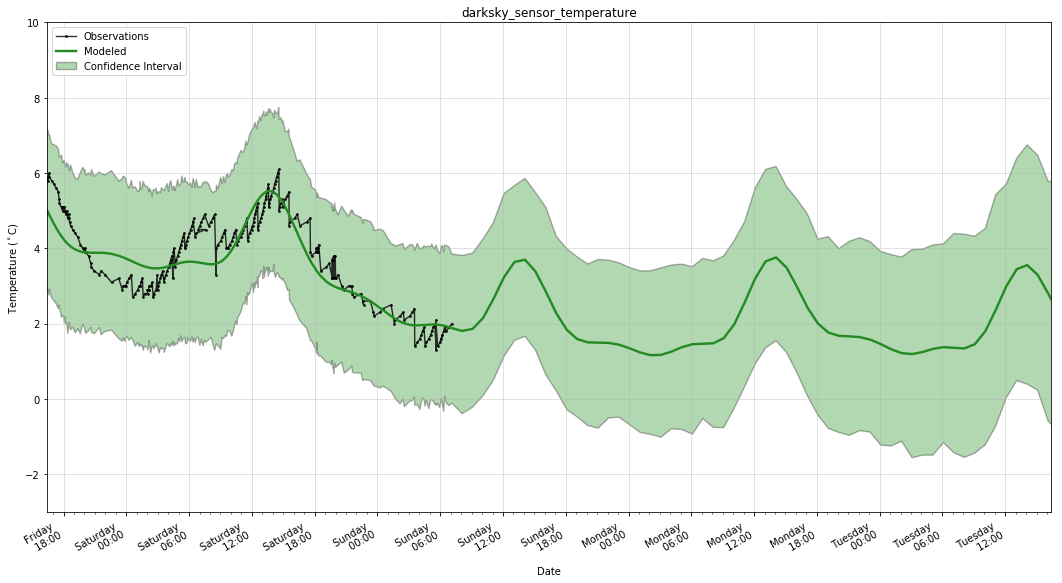

In [94]:
# Steal from Stocker to make a nicer plot
height=10
width=18

now = dt.datetime.now()
hours_to_plot = 24*2

fig, ax = plt.subplots(1, 1, figsize=(width, height))

ax.plot(df['ds'], df['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
    
ax.plot(forecast['ds'], forecast['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

# Plot the uncertainty interval as ribbon
ax.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_upper'], forecast['yhat_lower'], alpha = 0.3, 
facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

# Plot formatting
ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now+dt.timedelta(hours=hours_to_plot))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%A \n %H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(-3.0, 10.0)

plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Temperature ($^\circ$C)');
plt.grid(linewidth=0.6, alpha = 0.6)
title = 'darksky_sensor_temperature'
plt.title(title);
plt.savefig('darksky_sensor_temperature_precition.jpg')
fig.autofmt_xdate()
plt.show()

### Motion at home sensor
Lets focus on the binary_sensor.motion_at_home which is a sensor that indicates if there is any activity at home. In the pivot_table apply np.min to prevent np.mean (the default) from returning 0.5 in some cases (why is this?)

In [58]:
binary_sensors_df = df.query('domain == "binary_sensor"')
binary_sensors_list = list(binary_sensors_df.index.get_level_values('entity').unique())
print(len(binary_sensors_list))
binary_sensors_list

UndefinedVariableError: name 'domain' is not defined

In [ ]:
binary_sensors_df['state'] = binary_sensors_df['state'].apply(lambda x: binary_state(x)) # Binarise

In [ ]:
binary_sensors_df = binary_sensors_df.pivot_table(index='last_changed', columns='entity', values='state')

In [ ]:
binary_sensors_df.head()

In [ ]:
binary_sensors_df = binary_sensors_df.fillna(method='ffill')
binary_sensors_df = binary_sensors_df.dropna() # drop any remaining nan

Lets get only the motion sensor and put in a dataframe

In [ ]:
motion_df = binary_sensors_df["binary_sensor.motion_at_home"].to_frame() 

In [ ]:
motion_df.index = pd.to_datetime(motion_df.index)

#### Create some features
Lets get the weekday

In [ ]:
motion_df['weekday'] = motion_df.index.weekday_name

In [ ]:
motion_df['time'] = motion_df.index.time

In [ ]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: is_weekday(x))

In [ ]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [ ]:
motion_df['time_category'] = motion_df.index.map(lambda x: time_category(x))

In [ ]:
motion_df.head()

#### Analysis of motion data
Try a facet grid to represent data https://seaborn.pydata.org/generated/seaborn.FacetGrid.html?highlight=facet#seaborn.FacetGrid
Lets see if there is more motion at home on weekends.

In [ ]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

OK, so there is more activity at home on weekdays, but there are also 5 days in the working week and 2 in the weekend.

Now, how about activity by weekday.

And activity by weekday and time category.

In [ ]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
fig.savefig('heatmap.jpg')

## Bayesian sensor

In [ ]:
query = 'entity == "binary_sensor.in_bed_bayesian"'
in_bed_bayes_df = df.query(query)
in_bed_bayes_df.head()

In [ ]:
in_bed_bayes_df['state'].unique()

Hmm where are my on..

In [ ]:
in_bed_bayes_df.index = in_bed_bayes_df.index.get_level_values('last_changed')  # Keep only last_changed level

In [ ]:
in_bed_bayes_df.index = pd.to_datetime(in_bed_bayes_df.index)  # Convert to datetime

In [ ]:
f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')

In [ ]:
now = dt.datetime.now()
hours_to_plot = 240

f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')
xfmt = md.DateFormatter('%d %H:%M:%S') # %m-
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now)
ax.set_ylabel('In bed status', color='b')